In [487]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.reload_library()
from  matplotlib.ticker import FuncFormatter
import itertools
from src.config import chemical_inventory_path, raw_data_path
from src.data import notebook_utils as utils
from src.constants import GBL_INCHI_KEY, DMSO_INCHI_KEY, DMF_INCHI_KEY, \
                        INCHI_TO_CHEMNAME, TARGET_COL, RXN_FEAT_NAME, ORGANOAMONIUM_INCHI_KEY_COL
from src import plot_utils
# Import CMasher to register colormaps
import cmasher as cmr

In [2]:
%cd ../..

/home/belu/VS Workplace/licentiate-thesis-repo


In [488]:
df = utils.read_data(raw_data_path, organic_key=True, solvent=None)

/home/belu/.local/share/virtualenvs/licentiate-thesis-repo-cz9ujhZI/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Amines Pre-processing

### Filter unknown features

In [489]:
unknown_cols = ["_feat_ProtPolarSurfaceArea", "_feat_Protpsa",
                "_feat_molsurfaceareaASAp", "_feat_molsurfaceareaVDWp",
                "_feat_msareaASAp", "_feat_msareaVDWp"]

feats = utils.chem_feats()

selected_FQ = [feat for feat in [ORGANOAMONIUM_INCHI_KEY_COL]+feats if feat not in unknown_cols]

amines_feats = df[selected_FQ].drop_duplicates()

#amines_feats = amines_feats.drop(ORGANOAMONIUM_INCHI_KEY_COL, axis=1)

amines_feats = amines_feats.set_index(ORGANOAMONIUM_INCHI_KEY_COL)

Clean up features names

In [490]:
feats = list(amines_feats.columns)

amines_names = [name[6:] for name in feats]

amines_names = [name.replace("_", " ") for name in amines_names]

amines_names = [name[:name.find(" ")] + name[name.find(" ")+1].upper() + name[name.find(" ")+2:]
               if (" " in name) else name for name in amines_names]

amines_names = [name.strip(' ') for name in amines_names]

In [494]:
map_chem_feat = dict(zip(amines_feats.columns, amines_names))

In [496]:
import json

with open('data/metadata/map_chem_feat_names.json', 'w') as fp:
    #json.dump(map_chem_feat, fp)

In [439]:
amines_feats.columns = amines_names

In [440]:
#amines_feats.to_csv("data/metadata/amines_chem_info_preprocesed.csv")

### Summary Amines Table

In [441]:
summary = round(amines_feats.describe().T.drop("count", axis=1), 2)

In [442]:
summary = summary.reset_index().rename(columns={"index": "Feature"})

In [422]:
summary["Nombre"] = amines_names

In [443]:
summary

,Feature,mean,std,min,25%,50%,75%,max
0,WienerPolarity,4.19,3.79,0.00,1.00,3.00,7.00,15.00
1,BondCount,17.72,6.33,7.00,14.00,18.00,21.00,40.00
2,frNH0,0.02,0.15,0.00,0.00,0.00,0.00,1.00
3,Refractivity,41.92,11.17,21.21,34.41,41.21,50.10,71.89
4,LargestRingSize,2.44,2.92,0.00,0.00,0.00,6.00,6.00
...,...,...,...,...,...,...,...,...
56,ASAP,62.10,34.58,13.65,41.63,50.92,79.62,155.76
57,frNH1,0.14,0.35,0.00,0.00,0.00,0.00,1.00
58,MaximalProjectionRadius,4.44,1.21,2.67,3.63,4.49,4.97,9.65
59,Hdonorcount,1.30,0.51,1.00,1.00,1.00,2.00,3.00


In [460]:
df_amines_names = pd.read_csv("data/metadata/describe_feat_fq_description.csv")

In [461]:
feats = list(df_amines_names.Feature)

amines_names = [name[6:] for name in feats]

amines_names = [name.replace("_", " ") for name in amines_names]

amines_names = [name[:name.find(" ")] + name[name.find(" ")+1].upper() + name[name.find(" ")+2:]
               if (" " in name) else name for name in amines_names]

amines_names = [name.strip(' ') for name in amines_names]

In [462]:
df_amines_names["Name"] = amines_names

In [464]:
df_amines_names.iloc[:,[9,1,2,3,4,5,6,7,8]].to_csv("data/metadata/FQ_features_summary_table.csv", index=None)

### FQ chem features

In [ ]:
df_amines_names = "data/FQ_amines_name.csv"
df_amines_features = "data/FQ_amines_feature.csv"

In [ ]:
df_amines_features = amines_feats[feat_list]

In [ ]:
df_amines_features.to_csv(df_amines_features, index=None)

In [ ]:
df_amines_features.columns = names_fq_list

In [ ]:
df_amines_features.to_csv(df_amines_names, index=None)

In [ ]:
df_amines_features.to_csv("data/feat_amines_names.csv", index=None)

## EDA: amines FQ descriptors

### Split by type of variables

In [12]:
df_amines_names = "data/FQ_amines_name.csv"
df_amines_features = "data/FQ_amines_feature.csv"

In [13]:
df = pd.read_csv(df_amines_names)

In [14]:
df.shape

(43, 61)

Filter constant amines

In [15]:
df = df.loc[:, (df != df.iloc[0]).any()]

In [600]:
unique_values = df.select_dtypes(include="number").nunique().sort_values()

unique_values = unique_values.to_frame("count").reset_index().rename(columns = {'index':'propiedad'})

plot_title = "figures/propiedades_valores_unicos.pdf"

In [601]:
unique_values['type_var'] = pd.cut(unique_values['count'],
                              bins=[0, 2, 14, 50],
                              labels=["binaria", "ordinal", "continua"])

In [602]:
unique_values['range_unique_values'] = pd.cut(unique_values['count'],
                              bins=[1, 2, 14, 50])

In [603]:
unique_values.shape

(57, 4)

In [604]:
outlier_value_index = unique_values[unique_values.propiedad == "PolarSurfaceArea"].index[0]
unique_values.at[outlier_value_index, "type_var"] = "continua"

In [605]:
unique_values[unique_values.propiedad == "PolarSurfaceArea"]

,propiedad,count,type_var,range_unique_values
32,PolarSurfaceArea,11,continua,"(2, 14]"


In [606]:
df_type_var = unique_values.groupby("type_var").aggregate({"type_var":'first',
                                                           "range_unique_values": 'last',
                                                           "propiedad": 'count'})

In [607]:
df_type_var

,type_var,range_unique_values,propiedad
type_var,,,
binaria,binaria,"(1, 2]",17
ordinal,ordinal,"(2, 14]",18
continua,continua,"(14, 50]",22


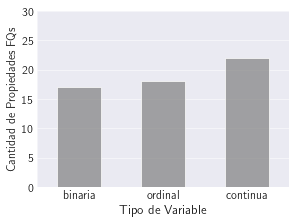

In [610]:
plot_title = "figures/propiedades_valores_unicos.pdf"

        
with plt.style.context(['science', 'bright']):
    #sns.set_palette(sns.color_palette(color_bright))
    fig, axes = plt.subplots(1, 1, figsize=(4,3),
                                 constrained_layout = True)
    ax = sns.barplot(x=df_type_var.index, y="propiedad", orient="v", data=df_type_var,
                     color="grey", alpha=0.7)
    #ax.set_title("Distribución Calidad de Cristal")

    # Remove box lines
    sns.despine(bottom = True, left = False, trim=False)
    ax.tick_params(which="both", left=False, bottom=False, top=False, right=False)
    #ax.xticks(fontdict={'fontsize':15})
    #ax.tick_params(axis='both', which='both')
    ax.set_ylabel("Cantidad de Propiedades FQs", fontdict={'fontsize':12})
    ax.set_xlabel("Tipo de Variable", fontdict={'fontsize':13})
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    #plt.xticks()
    plt.xticks(fontsize=12, rotation=0)
    plt.yticks(fontsize=12, rotation=0)
    

    for n, p in enumerate(ax.patches):
        text = str(df_type_var.iloc[n,1])
        width = p.get_width()
        new_width = width * 0.65
        p.set_width(new_width)
        x = p.get_x()
        p.set_x(x + (width - new_width) / 2)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() * 1.075
#        ax.annotate(text, (x, y), ha='center', va='center', fontsize=12)

    #plt.legend(title="Tipo de Variable", fontsize=13)
    plt.ylim(0,30)
    fig.savefig(plot_title, dpi=300)
    

In [ ]:
unique_values.to_csv("data/metadata/type_var_fq_bins.csv", index=None)

In [399]:
unique_values = pd.read_csv("data/metadata/type_var_fq_bins.csv")

In [409]:
table_type_var = unique_values.groupby("type_var").aggregate({"type_var":'first',
                                                           "range_unique_values": 'last',
                                                           "propiedad": 'count'})

In [414]:
table_type_var.iloc[[0,2,1],[0,2]].to_csv("data/metadata/bin_ord_cont_table.csv", index=None)

In [ ]:
def plot_type_vars(df): 
    unique_values = df.select_dtypes(include="number").nunique().sort_values()

    unique_values = unique_values.to_frame("count").reset_index().rename(columns = {'index':'propiedad'})

    unique_values['type_var'] = pd.cut(unique_values['count'],
                              bins=[0, 2, 11, 15, 50],
                              labels=["binario", "ordinal","precontinua", "continua"])
    
    plot_title = "figures/propiedades_valores_unicos.pdf"
    with plt.style.context(['science', 'bright']):
        #sns.set_palette(sns.color_palette(color_bright))
        fig, axes = plt.subplots(1, 1, figsize=(6,15),
                                     constrained_layout = True)
        ax = sns.barplot(x="count", y="propiedad", orient="h", data=unique_values,
                        hue="type_var")
        #ax.set_title("Distribución Calidad de Cristal")

        # Remove box lines
        sns.despine(bottom = True, left = True, trim=False)
        ax.tick_params(which="both", left=False, bottom=False, top=False, right=False)
        #ax.xticks(fontdict={'fontsize':15})
        #ax.tick_params(axis='both', which='both')
        ax.set_xlabel("Valores únicos por atributo", fontdict={'fontsize':13})
        ax.set_ylabel("Descriptores físico-químicos", fontdict={'fontsize':13})
        #plt.xticks()
        plt.xticks(fontsize=10, rotation=0)
        plt.yticks(fontsize=10, rotation=0)
        plt.legend(title="Tipo de Variable", fontsize=13)
        #ax.set(adjustable='box')
        #fig.savefig(plot_title, dpi=300)
    

### Variables no binarias - correlación

In [477]:
df_cont_col = pd.read_csv("data/metadata/type_var_fq_bins.csv")
cont_cols = df_cont_col[df_cont_col.type_var != "binaria"]["propiedad"]

In [478]:
df = pd.read_csv("data/feat_amines_names.csv")[cont_cols]

In [479]:
len(cont_cols)

40

In [480]:
df_cont_col = df_cont_col.rename(columns={"type_var": "Tipo de Variable"})

labels = df_cont_col[df_cont_col["Tipo de Variable"] != "binaria"]["Tipo de Variable"]

muted = plot_utils.tol_cset("muted")

bright = plot_utils.tol_cset("bright")

light = plot_utils.tol_cset("light")

In [481]:
bright_reorderd = [light.pear, muted.rose]
lut = dict(zip(labels.unique(), bright_reorderd))

In [482]:
label_color = pd.Series(list(labels), index=df.columns, name="Tipo de Variable").map(lut)

In [485]:
from matplotlib.patches import Patch
#fig, ax = plt.subplots(1, 1, figsize=(6,15), constrained_layout = True)

def plot_non_binary(cmap):

    plot_title = "figures/correlations_non_binary_sinlatex.pdf"
    #with plt.style.context(['science', 'bright']):


    ax = sns.clustermap(df.corr(method="spearman"), row_cluster=True, 
                        col_colors=label_color, cmap=cmap, 
                        row_colors=label_color, alpha=1,
                        dendrogram_ratio=(.1, .2),
                        cbar_pos=(.02, .4, .03, .2),
                        linewidths=.7, figsize=(18, 15),
                        cbar_kws={"ticks": list(np.arange(-1,1.1,0.2))},
                        vmin=-1,
                        vmax=1,
                       )
    handles = [Patch(facecolor=lut[name]) for name in lut]
    plt.legend(handles, lut, title='',
               bbox_to_anchor=(0.93, 0.9), bbox_transform=plt.gcf().transFigure,
               facecolor='white', framealpha=1, frameon=True, fontsize=13,)

    ax.ax_row_dendrogram.remove()
    ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xmajorticklabels(), fontsize = 13)
    ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_ymajorticklabels(), fontsize = 13)
    ax.ax_row_colors.set_xticklabels(labels=["Tipo de  Variable"], fontdict={'fontsize':12,
                                              'weight':'bold'})
    ax.ax_col_colors.set_yticklabels(labels=["Tipo de  Variable"], fontdict={'fontsize':12,
                                              'weight':'bold'})
    ax.ax_cbar.set_title("Correlación \n de Spearman", y=1.05, fontdict={'fontsize':12,
                                                                        'weight':'bold'})
    ax.ax_cbar.tick_params(labelsize=12, pad=10, length=4, grid_color='white', grid_linewidth=0.5, grid_alpha=1)
    
    #ax.ax_cbar  .dividers.set_color('white')
    #ax.ax_cbar.dividers.set_linewidth(2)
    #for spine in ax.ax_cbar.spines:
     #   ax.ax_cbar.spines[spine].set_color('crimson')
      #  ax.ax_cbar.spines[spine].set_linewidth(2)

    for t in ax.ax_cbar.get_yticklabels():
        t.set_horizontalalignment('right')   
        t.set_x(1.6)
    ax.fig.savefig(plot_title, dpi=300) 

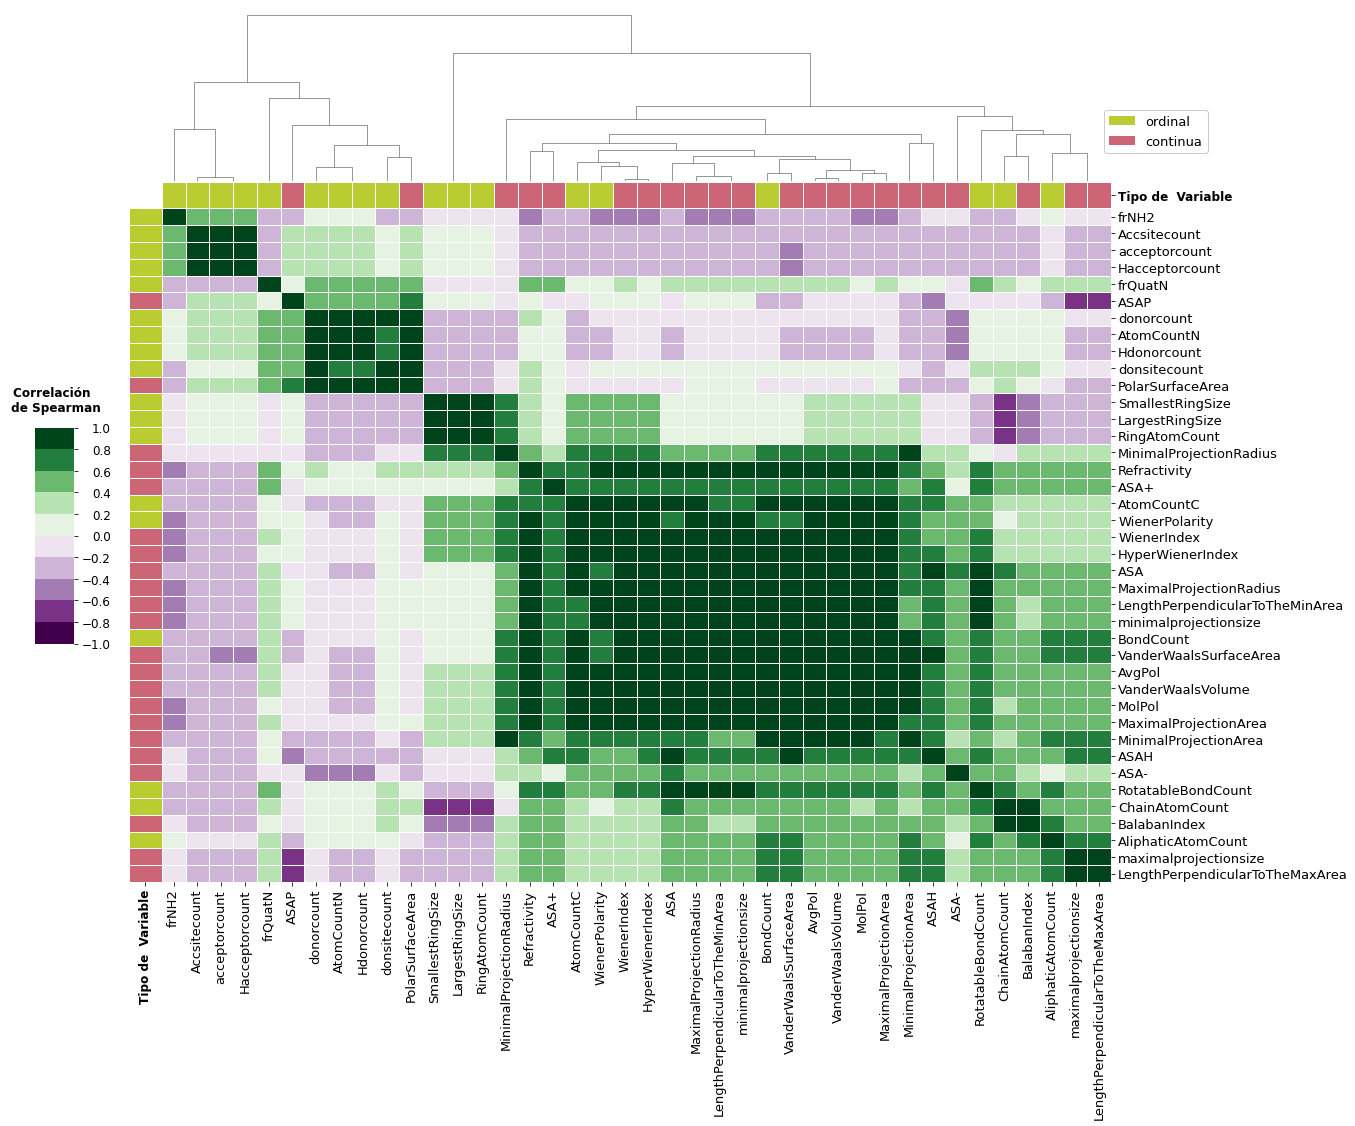

In [ ]:
ax = plot_non_binary(plt.get_cmap('PRGn', 10))

### Organoamines categories

#### Prejoined filtered feats and good names

In [86]:
df_feats = pd.read_csv("data/metadata/type_var_fq_bins.csv")

In [87]:
df_amines = utils.get_organoamines()

/home/belu/.local/share/virtualenvs/licentiate-thesis-repo-cz9ujhZI/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [88]:
df_amines_feats = pd.read_csv("data/metadata/amines_chem_info_preprocesed.csv")[df_feats.propiedad.to_list() + [ORGANOAMONIUM_INCHI_KEY_COL]]

In [89]:
df_amines_feats.shape

(43, 58)

In [90]:
joined_amine_info = df_amines_feats.join(other=df_amines.set_index(ORGANOAMONIUM_INCHI_KEY_COL), on=ORGANOAMONIUM_INCHI_KEY_COL)

In [97]:
joined_amine_info.to_csv("data/amines_cleaned_feats_plus_names.csv", index=None)

#### Plot categories

In [384]:
df_amines = pd.read_csv("data/amines_cleaned_feats_plus_names.csv")

##### Tipo de amina

In [385]:
amines_type_cols = [name for name in df_amines.columns if name.startswith(('frNH', 'frQuatN', 'frAr NH')) ]

In [386]:
amines_type_cols

['frNH1', 'frAr NH', 'frNH0', 'frQuatN', 'frNH2']

In [387]:
amines_tipe = dict(zip(amines_type_cols, ["secundaria", "aromática", "terciaria", "cuaternaria", "primaria"]))

In [388]:
amines_tipe

{'frNH1': 'secundaria',
 'frAr NH': 'aromática',
 'frNH0': 'terciaria',
 'frQuatN': 'cuaternaria',
 'frNH2': 'primaria'}

In [389]:
df_amine_groups = df_amines[amines_type_cols + ["Chemical Name"]]

df_by_tipo = df_amine_groups[amines_type_cols].T
df_by_tipo.columns = df_amine_groups["Chemical Name"].to_list()

df_amines_type = df_by_tipo[df_by_tipo > 0].count(axis=1)

In [390]:
df_amines_type = df_amines_type.to_frame("count").reset_index()

In [391]:
df_amines_type

,index,count
0,frNH1,6
1,frAr NH,1
2,frNH0,1
3,frQuatN,40
4,frNH2,9


In [392]:
df_amines_type["tipo_amina"] = df_amines_type["index"].map(amines_tipe)

In [393]:
df_amines_type.loc[[4,0,2,3,1]].iloc[:,[2,0,1]].to_csv("data/metadata/type_amines_to_table.csv", index=None)

##### Aromáticas vs anillo vs alifáticas

In [394]:
amines_type_cols = [name for name in df_amines.columns if name.endswith(('RingCount')) ]

In [395]:
amines_type_cols

['HeteroaromaticRingCount',
 'HeteroaliphaticRingCount',
 'CarboaromaticRingCount',
 'CarboaliphaticRingCount',
 'CarboRingCount',
 'AliphaticRingCount',
 'AromaticRingCount']

In [396]:
df_amine_groups = df_amines[amines_type_cols + ["Chemical Name"]]

df_by_tipo = df_amine_groups[amines_type_cols].T
df_by_tipo.columns = df_amine_groups["Chemical Name"].to_list()

df_amines_type = df_by_tipo[df_by_tipo > 0].count(axis=1)
df_amines_type = df_amines_type.to_frame("count").reset_index().rename({'index':'Propiedad'})

In [397]:
df_amines_type["Name"] = [name[:-5] for name in df_amines_type['index']]

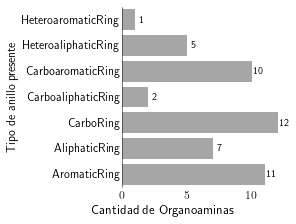

In [398]:
#plt.figure(figsize=(10, 7))
plot_title = "figures/amines_ring_count.pdf"
        
with plt.style.context(['science', 'bright']):
    #sns.set_palette(sns.color_palette(color_bright))
    fig, axes = plt.subplots(1, 1, figsize=(4,3),
                                 constrained_layout = True)
    ax = sns.barplot(data=df_amines_type, x="count", y="Name", orient="h",
                     color="grey", alpha=0.7)

    # Remove box lines
    sns.despine(bottom = True, left = False, trim=False)
    ax.tick_params(which="both", left=False, bottom=False, top=False, right=False)
    #ax.xticks([""],fontdict={'fontsize':15})
    #ax.tick_params(axis='both', which='both')
    ax.set_ylabel("Tipo de anillo presente", fontdict={'fontsize':12})
    ax.set_xlabel("Cantidad de Organoaminas", fontdict={'fontsize':13}, loc="center")
    ax.xaxis.set_label_coords(.25, -.1)
    #ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    #plt.xticks()
    plt.xticks(fontsize=12, rotation=0)
    plt.yticks(fontsize=12, rotation=0)
    
    for index, p in enumerate(ax.patches):
        #percentage = f'{100 * p.get_height() / total:.1f}\%\n'
        x = p.get_x() + p.get_width() + 0.5
        y = p.get_y() +  (p.get_height()/2)
        ax.annotate(df_amines_type.iloc[index,1], (x, y), ha='center', va='center')

#        ax.annotate(text, (x, y), ha='center', va='center', fontsize=12)

    #plt.legend(title="Tipo de Variable", fontsize=13)
    #plt.ylim(0,30)
    fig.savefig(plot_title, dpi=300)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def apply_pca(df, cols, n_components):
    scaler = StandardScaler()
    std_df =pd.DataFrame(scaler.fit_transform(df[cols]), columns=cols)
    pca_number = min(len(cols), n_components)
    pca_columns = ['PCA_'+ str(n) for n in range(1,pca_number+1)]
    pca = PCA(n_components=pca_number, svd_solver = 'auto')
    principal_components=pca.fit_transform(std_df)
    pca_df = pd.DataFrame(data = principal_components, columns = pca_columns)
    return pca, pca_df

In [ ]:
pca, pca_df = apply_pca(df, df.columns, 2)

In [ ]:
def plot_main_pca(df):
    df['group'] = ["Grupo 2" if x >= 0 else "Grupo 1" for x in df['PCA_2']]
    #df['group'] = np.where(df['PCA_1']>=12, 2)

    df.at[24, "group"] = "Outlier"

    bright = plot_utils.tol_cset("vibrant")
    bright_reorderd = [bright.magenta, bright.teal, bright.grey]

    colors = {"Grupo 1": bright.magenta, 
             "Grupo 2": bright.teal}

    from scipy import interpolate
    from scipy.spatial import ConvexHull
    #sns.set_palette(sns.color_palette("Paired"))
    #sns.set_context("paper")
    plot_title = "figures/organoaminas_pca_visual"
    with plt.style.context(['science', 'light']):
        #sns.set_palette(sns.color_palette(color_bright))

        fig, axes = plt.subplots(1, 1, sharey=True, sharex=False, figsize=(6,4),
                                 constrained_layout = True)

        #fig.suptitle('Distribución de Reactivos')

        sns.scatterplot(x="PCA_1", y="PCA_2", hue="group",
                        palette=bright_reorderd,
                    sizes=(1, 8), linewidth=0,
                    data=df, ax=axes)
        sns.despine(bottom = False, left = False, trim=False)
        axes.tick_params(which="both", left=True, bottom=False, top=False, right=False)
        axes.set_xlabel("1er Componente Principal",  fontdict={"size": 13})
        axes.set_ylabel("2da Componente Principal", fontdict={"size": 13})

        plt.xticks(fontsize=13, rotation=0)
        plt.yticks(fontsize=13, rotation=0)

        plt.legend(title="", loc=(0.8,0.8), fontsize=11)


        plt.vlines(x=0, ymin=-6, ymax=8,  ls='--', colors="black", alpha=0.7)
        plt.hlines(y=0, xmin=-13, xmax=18, ls='--', colors="black", alpha=0.7)
        #axes.axvline(12, ymin=0, ymax=2)

        #fig.supxlabel('Concentración (M)', fontdict={"size":12})
        #sns.color_palette()
        #fig.supylabel('Cantidad')
        #fig.savefig(plot_title+'.pdf', dpi=300)
        #fig.show()
        #plt.subplot_tool()

        for i in df.group.unique()[:2]:
            # get the convex hull
            points = df[df.group == i][['PCA_1', 'PCA_2']].values
            hull = ConvexHull(points)
            x_hull = np.append(points[hull.vertices,0],
                               points[hull.vertices,0][0])
            y_hull = np.append(points[hull.vertices,1],
                               points[hull.vertices,1][0])

            # interpolate
            dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
            dist_along = np.concatenate(([0], dist.cumsum()))
            spline, u = interpolate.splprep([x_hull, y_hull], 
                                            u=dist_along, s=0)
            interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
            interp_x, interp_y = interpolate.splev(interp_d, spline)
            # plot shape
            plt.fill(interp_x, interp_y, '--', alpha=0.3, c=colors[i])
        #fig.savefig(plot_title+'.pdf', dpi=300)


In [ ]:
def plot_amines_pca(df):
    #df['group'] = ["Grupo 2" if x >= 0 else "Grupo 1" for x in df['PCA_2']]
    #df['group'] = np.where(df['PCA_1']>=12, 2)

    #df.at[24, "group"] = "Outlier"

    bright = plot_utils.tol_cset("vibrant")
    bright_reorderd = [bright.magenta, bright.teal, bright.grey]

    colors = {"Grupo 1": bright.magenta, 
             "Grupo 2": bright.teal}

    from scipy import interpolate
    from scipy.spatial import ConvexHull
    #sns.set_palette(sns.color_palette("Paired"))
    #sns.set_context("paper")
    plot_title = "figures/organoaminas_pca_visual"
    with plt.style.context(['science', 'light']):
        #sns.set_palette(sns.color_palette(color_bright))

        fig, axes = plt.subplots(1, 1, sharey=True, sharex=False, figsize=(6,4),
                                 constrained_layout = True)

        #fig.suptitle('Distribución de Reactivos')

        sns.scatterplot(x="PCA_1", y="PCA_2",
                        palette=bright_reorderd,
                    sizes=(1, 8), linewidth=0,
                    data=df, ax=axes)
        sns.despine(bottom = False, left = False, trim=False)
        axes.tick_params(which="both", left=True, bottom=False, top=False, right=False)
        axes.set_xlabel("1er Componente Principal",  fontdict={"size": 13})
        axes.set_ylabel("2da Componente Principal", fontdict={"size": 13})

        plt.xticks(fontsize=13, rotation=0)
        plt.yticks(fontsize=13, rotation=0)

        plt.legend(title="", loc=(0.8,0.8), fontsize=11)


        plt.vlines(x=0, ymin=-6, ymax=8,  ls='--', colors="black", alpha=0.7)
        plt.hlines(y=0, xmin=-13, xmax=18, ls='--', colors="black", alpha=0.7)
        #axes.axvline(12, ymin=0, ymax=2)

        #fig.supxlabel('Concentración (M)', fontdict={"size":12})
        #sns.color_palette()
        #fig.supylabel('Cantidad')
        #fig.savefig(plot_title+'.pdf', dpi=300)
        #fig.show()
        #plt.subplot_tool()
        #fig.savefig(plot_title+'.pdf', dpi=300)


In [ ]:
plot_amines_pca(pca_df)

In [ ]:
pca.components_.shape

In [ ]:
from math import atan2, degrees
import math

def anti_clockwise(x,y):
    alpha = degrees(atan2(y,x))
    return (alpha + 360) % 360

def biplot(score, coeff, texts, cutoff=0):
    '''
    Author: Serafeim Loukas, serafeim.loukas@epfl.ch
    Inputs:
       score: the projected data
       coeff: the eigenvectors (PCs)
       y: the class labels
   '''
    
    xs = pd.DataFrame(np.transpose(pca.components_[0:2, :]))
    xs["name"] = texts

    xs["angle"] = xs.apply(lambda x: anti_clockwise(x[0], x[1]), axis=1)
    xs["norm"] = xs.apply(lambda x: LA.norm([x[0], x[1]]), axis=1)
    range_ls = list(range(0,420,60))
    xs["cuadrante"] = pd.cut(xs["angle"], range_ls, precision=0, labels=np.arange(1,len(range_ls)))
    norm_best = xs.groupby(["cuadrante"])["norm"].transform(max) == xs['norm']
    dots_to_plot = xs[norm_best].groupby("cuadrante").first()
    
    dots_to_plot["name"] = ["Cantidad de átomos de C",
                            "Tamaño del anillo más chico",
                            "Multiplicidad de aceptores de enlace de H",
                            "Área polar superficial",
                           #"Número de aminas aromáticas", 
                           "Cantidad de átomos H donores", 
                           "Cantidad de átomos en anillo aromático"]
    
    #print(norm_best)
    xs = score[:,0] # projection on PC1
    ys = score[:,1] # projection on PC2
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    n = coeff.shape[0] # number of variables
    plt.figure(figsize=(6,4), dpi=100)
    markers=['o','^','x']
    #plt.scatter(xs*scalex,ys*scaley, s=8) # color based on group
    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        #if xs["norm"] > cutoff:
        #    plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'k', alpha = 0.9,linestyle = '-',linewidth = 0.3)
        #    plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, texts[i], color = 'k', ha = 'center', va = 'center',fontsize=6)
        #else:
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'grey', alpha = 0.5,linestyle = '--',linewidth = 0.3)
    
    print(dots_to_plot)
    for row in dots_to_plot.iterrows():
        if row[1][0] < 0:
            plt.text(row[1][0]*1.9*(len(texts[a])*0.06), row[1][1]*1.05, s=row[1]["name"], color = 'k', ha = 'center', va = 'center',fontsize=6)
        else:
            plt.text(row[1][0], row[1][1]*1.05, s=row[1]["name"], color = 'k', ha = 'center', va = 'center',fontsize=6)
            
        
    plt.xlabel("PC{}".format(1), size=11)
    plt.ylabel("PC{}".format(2), size=11)
    limx= 0.3
    limy= 0.4
    plt.xlim([-limx,limx])
    plt.ylim([-limy,limy])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=12)


In [ ]:
#cols = df.columns

xs = pd.DataFrame(np.transpose(pca.components_[0:2, :]))
xs["name"] = cols
xs["angle"] = xs.apply(lambda x: anti_clockwise(x[0], x[1]), axis=1)
xs["norm"] = xs.apply(lambda x: LA.norm([x[0], x[1]]), axis=1)
xs["cuadrante"] = pd.cut(xs["angle"],list(range(0,420,60)), precision=0, labels=np.arange(1,7))
norm_best = xs.groupby(["cuadrante"])["norm"].transform(max) == xs['norm']
dots_to_plot = xs[norm_best].groupby("cuadrante").first()

dots_to_plot["name"] = ["Cantidad de átomos de C",
                        "Tamaño del anillo más chico",
                        "Multiplicidad de aceptores de enlace de H",
                        "Área polar superficial",
                       #"Número de aminas aromáticas", 
                       "Cantidad de átomos H donores", 
                       "Cantidad de átomos en anillo aromático"]

In [ ]:
biplot(pca_df.values, np.transpose(pca.components_[0:2, :]), df.columns, 0.40)

In [ ]:
n_components = 5
pca, pca_df = apply_pca(df, df.columns, n_components)

In [ ]:
pca.components_.shape

In [ ]:
pca.components_[:, :].T.shape

In [ ]:
loadings = pd.DataFrame(pca.components_[:, :].T, columns=["PC %s" % s for s in range(1,n_components+1)], index=df.columns)

In [ ]:
loadings.columns

In [ ]:
df.head()

In [ ]:
sns.clustermap(loadings[["PC 1", "PC 2"]], col_cluster=False)

In [ ]:
def plot_scree_pca(df):
    with plt.style.context(['science', 'light']):
    #sns.set_palette(sns.color_palette(color_bright))
        plot_title = "figures/pca_varianza"
        
        fig, axes = plt.subplots(1, 1, sharey=True, sharex=False, figsize=(4,4),
                                 constrained_layout = True)
        #fig.suptitle('Distribución de Reactivos')
        sns.barplot(x="Componente", y="Varianza Explicada", data=df, ax=axes, color='grey', alpha=0.50)
        
        news_x = [p.get_x() + p.get_width() / 2 for p in axes.patches]
        
        #sb.regplot(x='round', y='money', data=firm, ax=ax)
        sns.lineplot(x=news_x, y=df["Varianza Explicada Acumulada"], marker='o', legend="auto", color='grey', alpha=0.9, 
                     ax=axes)

        plt.xlabel('Número de componentes', fontsize=12)
        plt.ylabel('Varianza explicada', fontsize=12)
        
           
        plt.xticks(fontsize=13, rotation=0)
        plt.yticks(fontsize=13, rotation=0)

        sns.despine(bottom = False, left = False, trim=False)
        axes.tick_params(which="both", left=True, bottom=False, top=False, right=False)
    
        plt.ylim(0, 1)
        
        #fig.savefig(plot_title+'.pdf', dpi=300)
        

In [ ]:
pca, pca_df = apply_pca(df, df.columns, n_components)
explained = pd.DataFrame({"Componente":np.arange(1,n_components+1), "Varianza Explicada Acumulada":np.cumsum(pca.explained_variance_ratio_),
                         "Varianza Explicada": pca.explained_variance_ratio_})

In [ ]:
plot_scree_pca(explained)

In [ ]:
pca_df.shape

In [ ]:
pca.explained_variance_ratio_

In [ ]:
pca.components_.shape

In [ ]:
plot_scree_pca(pca)

In [ ]:
df_corr = df.corr()

In [ ]:
dataplot = sns.heatmap(df_corr, cmap="YlGnBu", annot=False)

In [ ]:
corr_fq

In [ ]:
dataplot = sb.heatmap(data.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
mp.show()